# EDA: Olist Brazilian E-commerce

## Objetivos
1. **Cargar y explorar** múltiples tablas CSV
2. **Analizar reviews** (portugués) y su relación con ventas
3. **Explorar correlación** entre sentiment y revenue
4. **Diseñar features** para predicción de ventas
5. **Identificar** patrones temporales

## Características del Dataset
- **Idioma**: Portugués
- **Formato**: Múltiples CSV relacionados
- **CON timestamps**: Análisis temporal posible
- **CON precios**: Predicción de ventas posible

## Tablas Disponibles
- `olist_orders_dataset.csv` - Órdenes
- `olist_order_items_dataset.csv` - Items por orden
- `olist_order_reviews_dataset.csv` - Reviews
- `olist_products_dataset.csv` - Productos
- `product_category_name_translation.csv` - Traducción categorías

---

In [1]:
# Setup e imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# === DETECCION ROBUSTA DEL PROJECT ROOT ===
def find_project_root() -> Path:
    """Busca la raiz del proyecto (donde esta pyproject.toml)."""
    notebook_dir = Path.cwd()
    for parent in [notebook_dir] + list(notebook_dir.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    if notebook_dir.name == "notebooks":
        return notebook_dir.parent
    return notebook_dir

project_root = find_project_root()
sys.path.insert(0, str(project_root / "src"))

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette('husl')

from tfm.config.settings import get_settings, BRONZE_FILES, PROJECT_ROOT
from tfm.tools.nlp_utils import (
    clean_text_portuguese, compute_sentiment_baseline,
    extract_text_features, analyze_star_distribution
)

settings = get_settings()
print(f"Project root: {PROJECT_ROOT}")
print(f"Olist Bronze dir: {settings.olist_bronze_dir}")
print(f"Es ruta absoluta: {settings.olist_bronze_dir.is_absolute()}")
print(f"\nArchivos disponibles:")
for name, file in BRONZE_FILES['olist'].items():
    path = settings.olist_bronze_dir / file
    exists = "SI" if path.exists() else "NO"
    print(f"  [{exists}] {name}: {path.name}")

Project root: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents
Olist Bronze dir: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\bronze\olist_ecommerce
Es ruta absoluta: True

Archivos disponibles:
  [SI] orders: olist_orders_dataset.csv
  [SI] items: olist_order_items_dataset.csv
  [SI] reviews: olist_order_reviews_dataset.csv
  [SI] products: olist_products_dataset.csv
  [SI] customers: olist_customers_dataset.csv
  [SI] sellers: olist_sellers_dataset.csv
  [SI] categories: product_category_name_translation.csv


## 1. Carga de Datos

In [2]:
# Cargar todas las tablas de Olist
olist_path = settings.olist_bronze_dir

# Reviews
df_reviews = pl.read_csv(olist_path / BRONZE_FILES['olist']['reviews'])
print(f"Reviews: {df_reviews.height:,} filas")

# Orders
df_orders = pl.read_csv(olist_path / BRONZE_FILES['olist']['orders'])
print(f"Orders: {df_orders.height:,} filas")

# Items
df_items = pl.read_csv(olist_path / BRONZE_FILES['olist']['items'])
print(f"Items: {df_items.height:,} filas")

# Products
df_products = pl.read_csv(olist_path / BRONZE_FILES['olist']['products'])
print(f"Products: {df_products.height:,} filas")

# Category translation
df_categories = pl.read_csv(olist_path / BRONZE_FILES['olist']['categories'])
print(f"Categories: {df_categories.height:,} filas")

print("\n Todos los datasets cargados")

Reviews: 99,224 filas
Orders: 99,441 filas
Items: 112,650 filas
Products: 32,951 filas
Categories: 71 filas

 Todos los datasets cargados


In [3]:
# Explorar estructura de reviews
print("REVIEWS - Columnas:")
print(df_reviews.columns)
print("\nPrimeras filas:")
df_reviews.head()

REVIEWS - Columnas:
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

Primeras filas:


review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
str,str,i64,str,str,str,str
"""7bc2406110b926393aa56f80a40eba…","""73fc7af87114b39712e6da79b0a377…",4,null,null,"""2018-01-18 00:00:00""","""2018-01-18 21:46:59"""
"""80e641a11e56f04c1ad469d5645fdf…","""a548910a1c6147796b98fdf73dbeba…",5,null,null,"""2018-03-10 00:00:00""","""2018-03-11 03:05:13"""
"""228ce5500dc1d8e020d8d1322874b6…","""f9e4b658b201a9f2ecdecbb34bed03…",5,null,null,"""2018-02-17 00:00:00""","""2018-02-18 14:36:24"""
"""e64fb393e7b32834bb789ff8bb3075…","""658677c97b385a9be170737859d351…",5,null,"""Recebi bem antes do prazo esti…","""2017-04-21 00:00:00""","""2017-04-21 22:02:06"""
"""f7c4243c7fe1938f181bec41a392bd…","""8e6bfb81e283fa7e4f11123a3fb894…",5,null,"""Parabéns lojas lannister adore…","""2018-03-01 00:00:00""","""2018-03-02 10:26:53"""


## 2. Análisis de Reviews

In [4]:
# Análisis de reviews con/sin texto
# Combinar título y mensaje
df_reviews = df_reviews.with_columns([
    # Verificar si tiene comentario
    (pl.col('review_comment_message').is_not_null() & 
     (pl.col('review_comment_message') != '')).alias('has_comment'),
    # Combinar título y mensaje
    pl.when(pl.col('review_comment_message').is_not_null())
    .then(pl.concat_str([
        pl.col('review_comment_title').fill_null(''),
        pl.lit(' '),
        pl.col('review_comment_message').fill_null('')
    ]))
    .otherwise(pl.col('review_comment_title'))
    .alias('text'),
    # Marcar ambiguos
    (pl.col('review_score') == 3).alias('is_ambiguous'),
])

# Estadísticas de reviews con/sin texto
reviews_with_text = df_reviews.filter(pl.col('has_comment')).height
reviews_without_text = df_reviews.filter(~pl.col('has_comment')).height
total_reviews = df_reviews.height

print(f"Total reviews: {total_reviews:,}")
print(f"Con comentario: {reviews_with_text:,} ({reviews_with_text/total_reviews*100:.1f}%)")
print(f"Sin comentario: {reviews_without_text:,} ({reviews_without_text/total_reviews*100:.1f}%)")

Total reviews: 99,224
Con comentario: 40,977 (41.3%)
Sin comentario: 58,247 (58.7%)


Distribución de Review Score:
shape: (5, 3)
┌──────────────┬───────┬────────────┐
│ review_score ┆ count ┆ percentage │
│ ---          ┆ ---   ┆ ---        │
│ i64          ┆ u32   ┆ f64        │
╞══════════════╪═══════╪════════════╡
│ 1            ┆ 11424 ┆ 11.51      │
│ 2            ┆ 3151  ┆ 3.18       │
│ 3            ┆ 8179  ┆ 8.24       │
│ 4            ┆ 19142 ┆ 19.29      │
│ 5            ┆ 57328 ┆ 57.78      │
└──────────────┴───────┴────────────┘

RESUMEN:
  Positivas (4-5): 77.1%
  Negativas (1-2): 14.7%
  Ambiguas (3):    8.2%


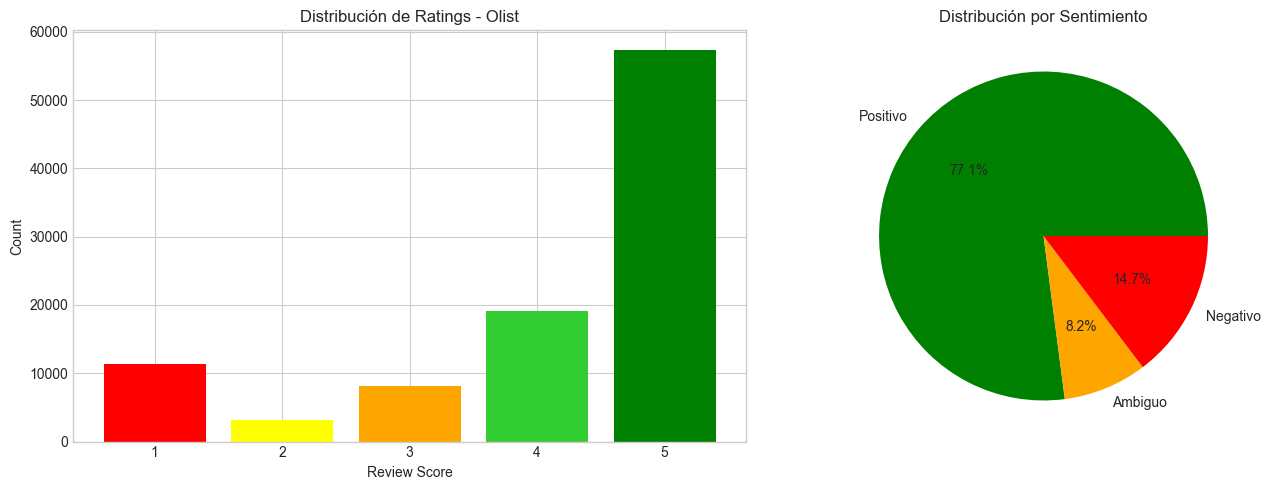

In [5]:
# Distribución de review_score
stars_dist = df_reviews.group_by('review_score').agg(pl.count().alias('count')).sort('review_score')
total = stars_dist['count'].sum()
stars_dist = stars_dist.with_columns((pl.col('count') / total * 100).round(2).alias('percentage'))

print("Distribución de Review Score:")
print(stars_dist)

pct_positive = stars_dist.filter(pl.col('review_score') >= 4)['percentage'].sum()
pct_negative = stars_dist.filter(pl.col('review_score') <= 2)['percentage'].sum()
pct_ambiguous = stars_dist.filter(pl.col('review_score') == 3)['percentage'].sum()

print(f"\nRESUMEN:")
print(f"  Positivas (4-5): {pct_positive:.1f}%")
print(f"  Negativas (1-2): {pct_negative:.1f}%")
print(f"  Ambiguas (3):    {pct_ambiguous:.1f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['red', 'yellow','orange', 'limegreen', 'green']
stars_pd = stars_dist.to_pandas()
axes[0].bar(stars_pd['review_score'], stars_pd['count'], color=colors)
axes[0].set_xlabel('Review Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribución de Ratings - Olist')

axes[1].pie([pct_positive, pct_ambiguous, pct_negative], 
            labels=['Positivo', 'Ambiguo', 'Negativo'],
            colors=['green', 'orange', 'red'], autopct='%1.1f%%')
axes[1].set_title('Distribución por Sentimiento')
plt.tight_layout()
plt.show()

## 3. Análisis de Ventas (Orders + Items)

In [6]:
# Análisis de órdenes
print("ORDERS - Columnas:")
print(df_orders.columns)

# Parsear fechas
df_orders = df_orders.with_columns([
    pl.col('order_purchase_timestamp').str.to_datetime('%Y-%m-%d %H:%M:%S').alias('purchase_date'),
])

df_orders = df_orders.with_columns([
    pl.col('purchase_date').dt.year().alias('year'),
    pl.col('purchase_date').dt.month().alias('month'),
    pl.col('purchase_date').dt.weekday().alias('day_of_week'),
])

# Rango de fechas
date_range = df_orders.select([
    pl.col('purchase_date').min().alias('min_date'),
    pl.col('purchase_date').max().alias('max_date'),
])
print(f"\nRango de fechas: {date_range}")

# Status de órdenes
status_counts = df_orders.group_by('order_status').agg(pl.count().alias('count')).sort('count', descending=True)
print("\nStatus de órdenes:")
print(status_counts)

ORDERS - Columnas:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Rango de fechas: shape: (1, 2)
┌─────────────────────┬─────────────────────┐
│ min_date            ┆ max_date            │
│ ---                 ┆ ---                 │
│ datetime[μs]        ┆ datetime[μs]        │
╞═════════════════════╪═════════════════════╡
│ 2016-09-04 21:15:19 ┆ 2018-10-17 17:30:18 │
└─────────────────────┴─────────────────────┘

Status de órdenes:
shape: (8, 2)
┌──────────────┬───────┐
│ order_status ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ delivered    ┆ 96478 │
│ shipped      ┆ 1107  │
│ canceled     ┆ 625   │
│ unavailable  ┆ 609   │
│ invoiced     ┆ 314   │
│ processing   ┆ 301   │
│ created      ┆ 5     │
│ approved     ┆ 2     │
└──────────────┴───────┘


In [7]:
# Análisis de items y precios
print("ITEMS - Columnas:")
print(df_items.columns)

# Estadísticas de precios
price_stats = df_items.select([
    pl.col('price').mean().alias('avg_price'),
    pl.col('price').median().alias('median_price'),
    pl.col('price').min().alias('min_price'),
    pl.col('price').max().alias('max_price'),
    pl.col('price').sum().alias('total_revenue'),
    pl.col('freight_value').mean().alias('avg_freight'),
])
print("\nEstadísticas de precios:")
print(price_stats)

# Revenue total
total_revenue = df_items['price'].sum() + df_items['freight_value'].sum()
print(f"\nRevenue total (price + freight): R$ {total_revenue:,.2f}")

ITEMS - Columnas:
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Estadísticas de precios:
shape: (1, 6)
┌────────────┬──────────────┬───────────┬───────────┬───────────────┬─────────────┐
│ avg_price  ┆ median_price ┆ min_price ┆ max_price ┆ total_revenue ┆ avg_freight │
│ ---        ┆ ---          ┆ ---       ┆ ---       ┆ ---           ┆ ---         │
│ f64        ┆ f64          ┆ f64       ┆ f64       ┆ f64           ┆ f64         │
╞════════════╪══════════════╪═══════════╪═══════════╪═══════════════╪═════════════╡
│ 120.653739 ┆ 74.99        ┆ 0.85      ┆ 6735.0    ┆ 1.3592e7      ┆ 19.99032    │
└────────────┴──────────────┴───────────┴───────────┴───────────────┴─────────────┘

Revenue total (price + freight): R$ 15,843,553.24


## 4. Correlación Reviews - Ventas

In [8]:
# Join reviews con orders para correlacionar
df_reviews_orders = df_reviews.join(
    df_orders.select(['order_id', 'purchase_date', 'year', 'month']),
    on='order_id',
    how='left'
)

# Join con items para obtener precios
df_reviews_items = df_reviews_orders.join(
    df_items.group_by('order_id').agg([
        pl.col('price').sum().alias('order_price'),
        pl.col('freight_value').sum().alias('order_freight'),
    ]),
    on='order_id',
    how='left'
)

# Correlación score vs precio
print("Correlación review_score vs precio de orden:")
score_price = df_reviews_items.filter(pl.col('order_price').is_not_null()).group_by('review_score').agg([
    pl.col('order_price').mean().alias('avg_price'),
    pl.col('order_price').median().alias('median_price'),
    pl.count().alias('count'),
]).sort('review_score')

print(score_price)

Correlación review_score vs precio de orden:
shape: (5, 4)
┌──────────────┬────────────┬──────────────┬───────┐
│ review_score ┆ avg_price  ┆ median_price ┆ count │
│ ---          ┆ ---        ┆ ---          ┆ ---   │
│ i64          ┆ f64        ┆ f64          ┆ u32   │
╞══════════════╪════════════╪══════════════╪═══════╡
│ 1            ┆ 166.559006 ┆ 99.0         ┆ 10884 │
│ 2            ┆ 145.289595 ┆ 89.9         ┆ 3089  │
│ 3            ┆ 127.626457 ┆ 82.99        ┆ 8126  │
│ 4            ┆ 132.294469 ┆ 83.97        ┆ 19109 │
│ 5            ┆ 134.489921 ┆ 84.99        ┆ 57257 │
└──────────────┴────────────┴──────────────┴───────┘


## 5. Prototipo NLP Portugués

In [9]:
# Ejemplos de reviews en portugués
sample_reviews = df_reviews.filter(pl.col('has_comment')).sample(5, seed=42)

print("Ejemplos de reviews en portugués:")
print("=" * 60)
for row in sample_reviews.iter_rows(named=True):
    print(f"\nScore: {row['review_score']}")
    text = row['text'][:300] if row['text'] else "(vacío)"
    print(f"Texto: {text}")
    
    # Probar limpieza
    if row['text']:
        cleaned = clean_text_portuguese(row['text'])
        print(f"Limpio: {cleaned[:100]}...")

print("\n" + "=" * 60)
print("NOTA: Para portugués, opciones de modelo:")
print("  - mBERT (multilingual BERT)")
print("  - Traducción a inglés/español")
print("  - Modelos específicos para portugués")

Ejemplos de reviews en portugués:

Score: 5
Texto:  muito boa, adorei o produto
Limpio: muito boa adorei o produto...

Score: 2
Texto:  
Os pneus que eu comprei só veio dois dos quatro que eu comprei 
Limpio: os pneus que eu comprei só veio dois dos quatro que eu comprei...

Score: 5
Texto:  Chegou tudo certo antes do prazo. produto bom 
Limpio: chegou tudo certo antes do prazo produto bom...

Score: 5
Texto:  Tudo certo
Limpio: tudo certo...

Score: 4
Texto:  Produto não chegou
Limpio: produto não chegou...

NOTA: Para portugués, opciones de modelo:
  - mBERT (multilingual BERT)
  - Traducción a inglés/español
  - Modelos específicos para portugués


## 6. Analisis Temporal de Ventas

Ordenes por mes:
shape: (12, 4)
┌──────┬───────┬──────────────┬────────────┐
│ year ┆ month ┆ orders_count ┆ year_month │
│ ---  ┆ ---   ┆ ---          ┆ ---        │
│ i32  ┆ i8    ┆ u32          ┆ str        │
╞══════╪═══════╪══════════════╪════════════╡
│ 2017 ┆ 11    ┆ 7544         ┆ 2017-11    │
│ 2017 ┆ 12    ┆ 5673         ┆ 2017-12    │
│ 2018 ┆ 1     ┆ 7269         ┆ 2018-01    │
│ 2018 ┆ 2     ┆ 6728         ┆ 2018-02    │
│ 2018 ┆ 3     ┆ 7211         ┆ 2018-03    │
│ …    ┆ …     ┆ …            ┆ …          │
│ 2018 ┆ 6     ┆ 6167         ┆ 2018-06    │
│ 2018 ┆ 7     ┆ 6292         ┆ 2018-07    │
│ 2018 ┆ 8     ┆ 6512         ┆ 2018-08    │
│ 2018 ┆ 9     ┆ 16           ┆ 2018-09    │
│ 2018 ┆ 10    ┆ 4            ┆ 2018-10    │
└──────┴───────┴──────────────┴────────────┘


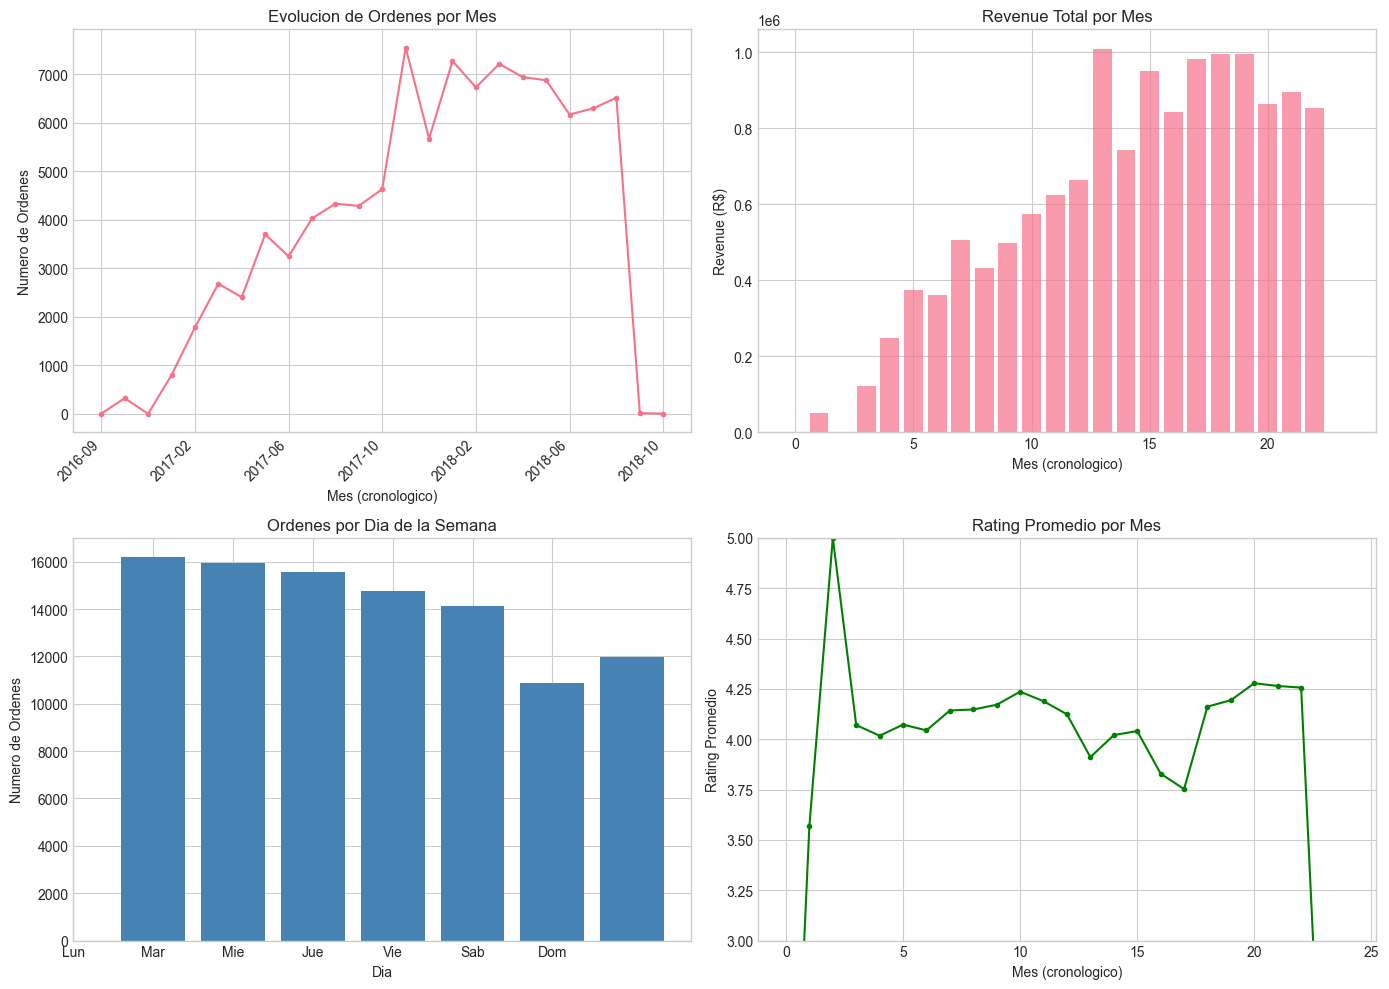

In [10]:
# Analisis temporal de ordenes
# Ventas por mes
orders_by_month = df_orders.group_by(['year', 'month']).agg([
    pl.count().alias('orders_count'),
]).sort(['year', 'month'])

# Crear columna de fecha para visualizacion
orders_by_month = orders_by_month.with_columns([
    (pl.col('year').cast(pl.Utf8) + '-' + pl.col('month').cast(pl.Utf8).str.zfill(2)).alias('year_month')
])

print("Ordenes por mes:")
print(orders_by_month.tail(12))

# Visualizacion temporal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ordenes por mes
orders_pd = orders_by_month.to_pandas()
axes[0, 0].plot(range(len(orders_pd)), orders_pd['orders_count'], marker='o', markersize=3)
axes[0, 0].set_title('Evolucion de Ordenes por Mes')
axes[0, 0].set_xlabel('Mes (cronologico)')
axes[0, 0].set_ylabel('Numero de Ordenes')
# Mostrar algunos ticks
tick_positions = list(range(0, len(orders_pd), 4))
tick_labels = [orders_pd['year_month'].iloc[i] for i in tick_positions]
axes[0, 0].set_xticks(tick_positions)
axes[0, 0].set_xticklabels(tick_labels, rotation=45, ha='right')

# Revenue por mes (unir con items)
items_with_date = df_items.join(
    df_orders.select(['order_id', 'year', 'month']),
    on='order_id',
    how='left'
)
revenue_by_month = items_with_date.group_by(['year', 'month']).agg([
    pl.col('price').sum().alias('total_revenue'),
    pl.col('price').mean().alias('avg_price'),
]).sort(['year', 'month'])

revenue_pd = revenue_by_month.to_pandas()
axes[0, 1].bar(range(len(revenue_pd)), revenue_pd['total_revenue'], alpha=0.7)
axes[0, 1].set_title('Revenue Total por Mes')
axes[0, 1].set_xlabel('Mes (cronologico)')
axes[0, 1].set_ylabel('Revenue (R$)')

# Ordenes por dia de la semana
orders_by_dow = df_orders.group_by('day_of_week').agg(pl.count().alias('count')).sort('day_of_week')
dow_names = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']
dow_pd = orders_by_dow.to_pandas()
axes[1, 0].bar(dow_pd['day_of_week'], dow_pd['count'], color='steelblue')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(dow_names)
axes[1, 0].set_title('Ordenes por Dia de la Semana')
axes[1, 0].set_xlabel('Dia')
axes[1, 0].set_ylabel('Numero de Ordenes')

# Rating promedio por mes
reviews_temporal = df_reviews_items.filter(pl.col('year').is_not_null())
rating_by_month = reviews_temporal.group_by(['year', 'month']).agg([
    pl.col('review_score').mean().alias('avg_score'),
    pl.count().alias('reviews_count'),
]).sort(['year', 'month'])

rating_pd = rating_by_month.to_pandas()
axes[1, 1].plot(range(len(rating_pd)), rating_pd['avg_score'], marker='o', color='green', markersize=3)
axes[1, 1].set_title('Rating Promedio por Mes')
axes[1, 1].set_xlabel('Mes (cronologico)')
axes[1, 1].set_ylabel('Rating Promedio')
axes[1, 1].set_ylim(3, 5)

plt.tight_layout()
plt.show()

## 7. Analisis de Productos y Categorias

In [11]:
# Explorar productos
print("PRODUCTS - Columnas:")
print(df_products.columns)
print(f"\nProductos unicos: {df_products.height:,}")

# Estadisticas de productos
product_stats = df_products.select([
    pl.col('product_name_lenght').mean().alias('avg_name_length'),
    pl.col('product_description_lenght').mean().alias('avg_desc_length'),
    pl.col('product_photos_qty').mean().alias('avg_photos'),
    pl.col('product_weight_g').mean().alias('avg_weight_g'),
    pl.col('product_category_name').n_unique().alias('unique_categories'),
])
print("\nEstadisticas de productos:")
print(product_stats)

# Top categorias por numero de productos
top_categories = df_products.group_by('product_category_name').agg([
    pl.count().alias('product_count'),
]).sort('product_count', descending=True).head(15)

print("\nTop 15 categorias por productos:")
print(top_categories)

PRODUCTS - Columnas:
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Productos unicos: 32,951

Estadisticas de productos:
shape: (1, 5)
┌─────────────────┬─────────────────┬────────────┬──────────────┬───────────────────┐
│ avg_name_length ┆ avg_desc_length ┆ avg_photos ┆ avg_weight_g ┆ unique_categories │
│ ---             ┆ ---             ┆ ---        ┆ ---          ┆ ---               │
│ f64             ┆ f64             ┆ f64        ┆ f64          ┆ u32               │
╞═════════════════╪═════════════════╪════════════╪══════════════╪═══════════════════╡
│ 48.476949       ┆ 771.495285      ┆ 2.188986   ┆ 2276.472488  ┆ 74                │
└─────────────────┴─────────────────┴────────────┴──────────────┴───────────────────┘

Top 15 categorias por productos:
shape: (15, 2)
┌─────────────────────────────┬───────────────┐
│ product_categ

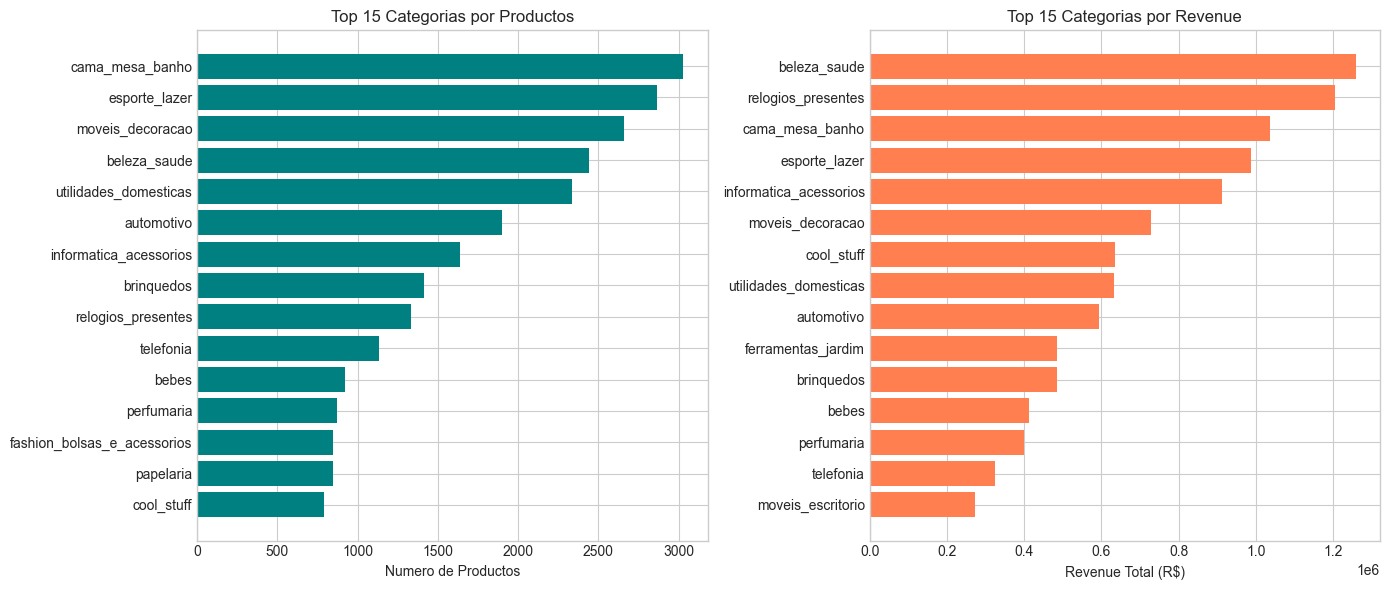


Top 15 categorias por revenue:
shape: (15, 3)
┌────────────────────────┬───────────────┬────────────┐
│ product_category_name  ┆ total_revenue ┆ items_sold │
│ ---                    ┆ ---           ┆ ---        │
│ str                    ┆ f64           ┆ u32        │
╞════════════════════════╪═══════════════╪════════════╡
│ beleza_saude           ┆ 1.2587e6      ┆ 9670       │
│ relogios_presentes     ┆ 1.2050e6      ┆ 5991       │
│ cama_mesa_banho        ┆ 1.0370e6      ┆ 11115      │
│ esporte_lazer          ┆ 988048.97     ┆ 8641       │
│ informatica_acessorios ┆ 911954.32     ┆ 7827       │
│ …                      ┆ …             ┆ …          │
│ brinquedos             ┆ 483946.6      ┆ 4117       │
│ bebes                  ┆ 411764.89     ┆ 3065       │
│ perfumaria             ┆ 399124.87     ┆ 3419       │
│ telefonia              ┆ 323667.53     ┆ 4545       │
│ moveis_escritorio      ┆ 273960.7      ┆ 1691       │
└────────────────────────┴───────────────┴────────────┘


In [12]:
# Visualizacion de categorias
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top categorias
top_cats_pd = top_categories.to_pandas()
axes[0].barh(top_cats_pd['product_category_name'], top_cats_pd['product_count'], color='teal')
axes[0].set_xlabel('Numero de Productos')
axes[0].set_title('Top 15 Categorias por Productos')
axes[0].invert_yaxis()

# Unir productos con items para analizar categorias con mas ventas
items_products = df_items.join(
    df_products.select(['product_id', 'product_category_name']),
    on='product_id',
    how='left'
)

# Revenue por categoria
revenue_by_category = items_products.group_by('product_category_name').agg([
    pl.col('price').sum().alias('total_revenue'),
    pl.count().alias('items_sold'),
]).sort('total_revenue', descending=True).head(15)

rev_cats_pd = revenue_by_category.to_pandas()
axes[1].barh(rev_cats_pd['product_category_name'], rev_cats_pd['total_revenue'], color='coral')
axes[1].set_xlabel('Revenue Total (R$)')
axes[1].set_title('Top 15 Categorias por Revenue')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 15 categorias por revenue:")
print(revenue_by_category)

In [13]:
# Analisis de reviews por categoria
# Unir reviews con productos via items y orders
reviews_with_products = df_reviews.join(
    df_orders.select(['order_id']),
    on='order_id',
    how='inner'
).join(
    df_items.select(['order_id', 'product_id']),
    on='order_id',
    how='left'
).join(
    df_products.select(['product_id', 'product_category_name']),
    on='product_id',
    how='left'
)

# Rating promedio por categoria
rating_by_category = reviews_with_products.group_by('product_category_name').agg([
    pl.col('review_score').mean().alias('avg_score'),
    pl.col('review_score').count().alias('review_count'),
]).filter(pl.col('review_count') >= 100).sort('avg_score', descending=True)

print("Top 10 categorias por rating promedio (min 100 reviews):")
print(rating_by_category.head(10))

print("\nBottom 10 categorias por rating promedio:")
print(rating_by_category.tail(10))

Top 10 categorias por rating promedio (min 100 reviews):
shape: (10, 3)
┌────────────────────────┬───────────┬──────────────┐
│ product_category_name  ┆ avg_score ┆ review_count │
│ ---                    ┆ ---       ┆ ---          │
│ str                    ┆ f64       ┆ u32          │
╞════════════════════════╪═══════════╪══════════════╡
│ livros_interesse_geral ┆ 4.446266  ┆ 549          │
│ livros_tecnicos        ┆ 4.368421  ┆ 266          │
│ alimentos_bebidas      ┆ 4.315412  ┆ 279          │
│ malas_acessorios       ┆ 4.315257  ┆ 1088         │
│ fashion_calcados       ┆ 4.233716  ┆ 261          │
│ alimentos              ┆ 4.218182  ┆ 495          │
│ papelaria              ┆ 4.193857  ┆ 2507         │
│ pet_shop               ┆ 4.185147  ┆ 1939         │
│ pcs                    ┆ 4.175     ┆ 200          │
│ eletrodomesticos       ┆ 4.172457  ┆ 806          │
└────────────────────────┴───────────┴──────────────┘

Bottom 10 categorias por rating promedio:
shape: (10, 3)
┌─────

## 8. Analisis Detallado de Texto de Reviews

Caracteristicas de texto por review_score:
shape: (5, 5)
┌──────────────┬────────────┬───────────────┬───────────┬───────┐
│ review_score ┆ avg_length ┆ median_length ┆ avg_words ┆ count │
│ ---          ┆ ---        ┆ ---           ┆ ---       ┆ ---   │
│ i64          ┆ f64        ┆ f64           ┆ f64       ┆ u32   │
╞══════════════╪════════════╪═══════════════╪═══════════╪═══════╡
│ 1            ┆ 104.179074 ┆ 93.0          ┆ 18.952659 ┆ 8745  │
│ 2            ┆ 101.064336 ┆ 92.0          ┆ 18.596737 ┆ 2145  │
│ 3            ┆ 87.018836  ┆ 74.0          ┆ 16.057071 ┆ 3557  │
│ 4            ┆ 65.264558  ┆ 50.0          ┆ 11.933568 ┆ 5976  │
│ 5            ┆ 55.772599  ┆ 46.0          ┆ 9.81624   ┆ 20554 │
└──────────────┴────────────┴───────────────┴───────────┴───────┘


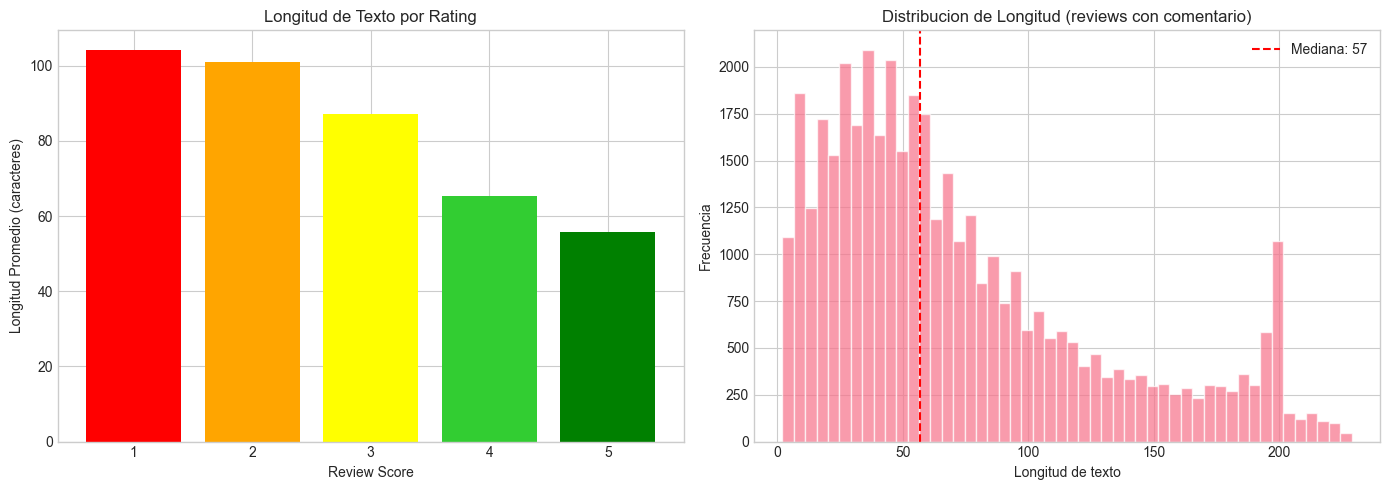

In [14]:
# Analisis de texto de reviews
# Agregar metricas de texto
df_reviews = df_reviews.with_columns([
    pl.col('text').str.len_chars().alias('text_length'),
    pl.col('text').str.split(' ').list.len().alias('word_count'),
])

# Estadisticas por score
text_by_score = df_reviews.filter(pl.col('has_comment')).group_by('review_score').agg([
    pl.col('text_length').mean().alias('avg_length'),
    pl.col('text_length').median().alias('median_length'),
    pl.col('word_count').mean().alias('avg_words'),
    pl.count().alias('count'),
]).sort('review_score')

print("Caracteristicas de texto por review_score:")
print(text_by_score)

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Longitud promedio por score
text_pd = text_by_score.to_pandas()
colors = ['red', 'orange', 'yellow', 'limegreen', 'green']
axes[0].bar(text_pd['review_score'], text_pd['avg_length'], color=colors)
axes[0].set_xlabel('Review Score')
axes[0].set_ylabel('Longitud Promedio (caracteres)')
axes[0].set_title('Longitud de Texto por Rating')

# Distribucion de longitud (reviews con comentario)
text_lengths = df_reviews.filter(
    pl.col('has_comment') & (pl.col('text_length') < 500)
)['text_length'].to_numpy()
axes[1].hist(text_lengths, bins=50, edgecolor='white', alpha=0.7)
axes[1].axvline(np.median(text_lengths), color='red', linestyle='--', 
                label=f'Mediana: {np.median(text_lengths):.0f}')
axes[1].set_xlabel('Longitud de texto')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribucion de Longitud (reviews con comentario)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# Analisis de reviews ambiguas (score = 3)
df_ambiguous_olist = df_reviews.filter(pl.col('is_ambiguous') & pl.col('has_comment'))

print(f"Reviews ambiguas con comentario: {df_ambiguous_olist.height:,}")
print(f"Porcentaje del total con comentario: {df_ambiguous_olist.height/reviews_with_text*100:.1f}%")

# Ejemplos de reviews ambiguas
print("\nEjemplos de reviews ambiguas (score=3):")
print("=" * 60)
ambiguous_samples = df_ambiguous_olist.sample(5, seed=42)
for row in ambiguous_samples.iter_rows(named=True):
    text = row['text'][:200] if row['text'] else "(vacio)"
    cleaned = clean_text_portuguese(text) if row['text'] else ""
    print(f"Score: {row['review_score']}")
    print(f"Texto: {text}...")
    print(f"Limpio: {cleaned[:100]}...")
    print("-" * 40)

Reviews ambiguas con comentario: 3,557
Porcentaje del total con comentario: 8.7%

Ejemplos de reviews ambiguas (score=3):
Score: 3
Texto:  Fiz uma compra só, o produto foi faturado junto saiu na mesma nota, quando chegou, veio só um com a nota com os 2, acabei reclamando e depois de 1 dia chegou o outro relógio, produto igual ao anúncio...
Limpio: fiz uma compra só o produto foi faturado junto saiu na mesma nota quando chegou veio só um com a not...
----------------------------------------
Score: 3
Texto:  recebi uma parte da compra,isto é, comprei 2 produtos e so recebi 1,porem a nota fiscal veio discriminando 2 produtos...
Limpio: recebi uma parte da compraisto é comprei produtos e so recebi porem a nota fiscal veio discriminando...
----------------------------------------
Score: 3
Texto: Na espera Nao recebi o produto ainda o correio ainda nao mr entregou ..estou esperando era pra eu ter recebido dia 24/4....
Limpio: na espera nao recebi o produto ainda o correio ainda nao mr entreg

## 9. Features para Prediccion de Ventas

In [16]:
# Diseño de features para prediccion de ventas
# Crear dataset consolidado para prediccion

# Agregar metricas por producto
product_metrics = df_items.group_by('product_id').agg([
    pl.count().alias('times_sold'),
    pl.col('price').mean().alias('avg_price'),
    pl.col('price').sum().alias('total_revenue'),
])

# Agregar rating promedio por producto
product_reviews = reviews_with_products.group_by('product_id').agg([
    pl.col('review_score').mean().alias('avg_review_score'),
    pl.col('review_score').count().alias('review_count'),
])

# Combinar
product_features = product_metrics.join(
    product_reviews,
    on='product_id',
    how='left'
).join(
    df_products.select(['product_id', 'product_category_name', 'product_weight_g']),
    on='product_id',
    how='left'
)

print("Features de producto para prediccion:")
print(product_features.head(10))

# Estadisticas de features
print("\nEstadisticas de features:")
feature_stats = product_features.select([
    pl.col('times_sold').mean().alias('avg_times_sold'),
    pl.col('avg_price').mean().alias('avg_avg_price'),
    pl.col('avg_review_score').mean().alias('avg_review_score'),
    pl.col('review_count').mean().alias('avg_review_count'),
])
print(feature_stats)

Features de producto para prediccion:
shape: (10, 8)
┌─────────────────────────────────┬────────────┬───────────┬───────────────┬──────────────────┬──────────────┬───────────────────────────────┬──────────────────┐
│ product_id                      ┆ times_sold ┆ avg_price ┆ total_revenue ┆ avg_review_score ┆ review_count ┆ product_category_name         ┆ product_weight_g │
│ ---                             ┆ ---        ┆ ---       ┆ ---           ┆ ---              ┆ ---          ┆ ---                           ┆ ---              │
│ str                             ┆ u32        ┆ f64       ┆ f64           ┆ f64              ┆ u32          ┆ str                           ┆ i64              │
╞═════════════════════════════════╪════════════╪═══════════╪═══════════════╪══════════════════╪══════════════╪═══════════════════════════════╪══════════════════╡
│ b7db6602d7706acf38d5b9a0e40300… ┆ 1          ┆ 76.99     ┆ 76.99         ┆ 5.0              ┆ 1            ┆ cama_mesa_banho           

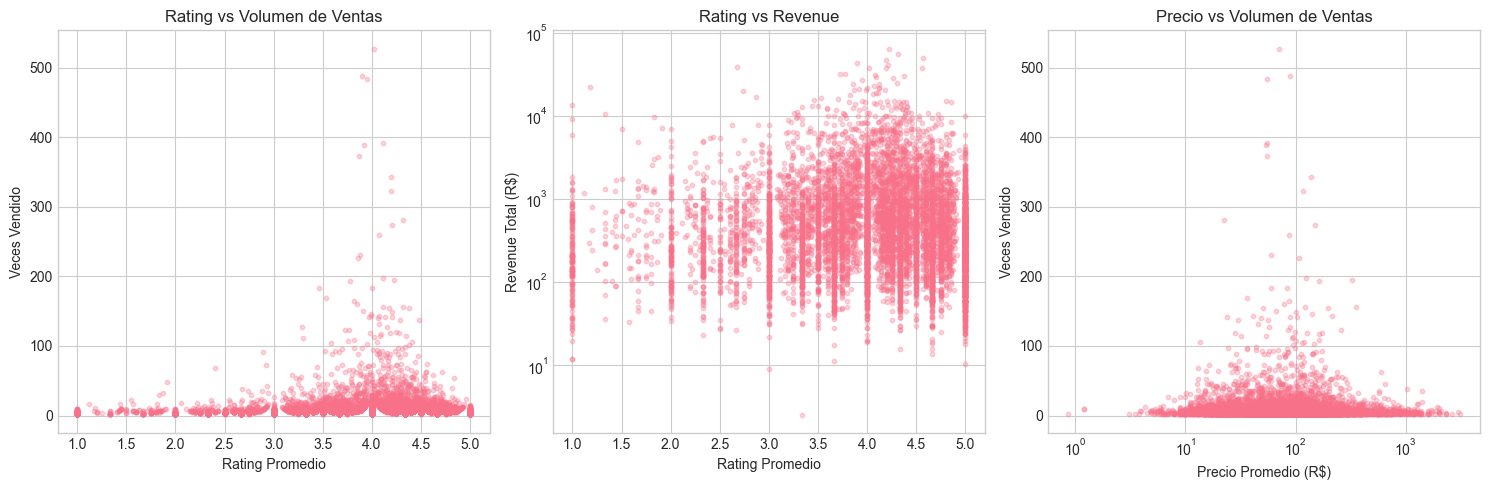


Correlaciones:
shape: (1, 3)
┌─────────────────┬────────────────────┬─────────────────┐
│ corr_score_sold ┆ corr_score_revenue ┆ corr_price_sold │
│ ---             ┆ ---                ┆ ---             │
│ f64             ┆ f64                ┆ f64             │
╞═════════════════╪════════════════════╪═════════════════╡
│ -0.000598       ┆ -0.005354          ┆ -0.027583       │
└─────────────────┴────────────────────┴─────────────────┘


In [17]:
# Correlacion review_score vs ventas
# Visualizar relacion entre rating y metricas de venta

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Filtrar productos con suficientes datos
products_with_data = product_features.filter(
    pl.col('review_count').is_not_null() & 
    (pl.col('review_count') >= 3)
)

# Score vs veces vendido
products_pd = products_with_data.to_pandas()
axes[0].scatter(products_pd['avg_review_score'], products_pd['times_sold'], alpha=0.3, s=10)
axes[0].set_xlabel('Rating Promedio')
axes[0].set_ylabel('Veces Vendido')
axes[0].set_title('Rating vs Volumen de Ventas')

# Score vs revenue
axes[1].scatter(products_pd['avg_review_score'], products_pd['total_revenue'], alpha=0.3, s=10)
axes[1].set_xlabel('Rating Promedio')
axes[1].set_ylabel('Revenue Total (R$)')
axes[1].set_title('Rating vs Revenue')
axes[1].set_yscale('log')

# Precio vs veces vendido
axes[2].scatter(products_pd['avg_price'], products_pd['times_sold'], alpha=0.3, s=10)
axes[2].set_xlabel('Precio Promedio (R$)')
axes[2].set_ylabel('Veces Vendido')
axes[2].set_title('Precio vs Volumen de Ventas')
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()

# Correlaciones
correlations = products_with_data.select([
    pl.corr('avg_review_score', 'times_sold').alias('corr_score_sold'),
    pl.corr('avg_review_score', 'total_revenue').alias('corr_score_revenue'),
    pl.corr('avg_price', 'times_sold').alias('corr_price_sold'),
])
print("\nCorrelaciones:")
print(correlations)

## 10. Conclusiones del EDA - Olist Brazilian E-commerce

### 10.1 Estructura de Datos

Olist es un dataset completo de e-commerce con multiples tablas relacionadas:

- **Reviews**: 99,224 registros con scores 1-5, timestamps y texto opcional (portugues)
- **Orders**: 99,441 ordenes con estados y timestamps de todo el ciclo de compra
- **Items**: 112,650 items con precios y datos de envio
- **Products**: 32,951 productos con categorias, dimensiones y peso
- **Categories**: 71 categorias con traduccion portugues-ingles

### 10.2 Hallazgos Clave

**Distribucion de Ratings:**
- Dataset positivamente sesgado: 77.1% son 4-5 estrellas
- Reviews negativas (1-2): 14.7%
- Reviews ambiguas (3): 8.2%
- Patron tipico de e-commerce donde la mayoria de compradores satisfechos no dejan review

**Caracteristicas de Reviews:**
- Solo 41.3% de reviews tienen comentario de texto
- 58.7% son solo rating numerico sin texto
- Implicacion: NLP solo aplicable a subset de datos
- Reviews negativas tienden a tener textos mas largos (explicacion de problemas)

**Analisis Temporal:**
- Datos desde Sep 2016 hasta Oct 2018
- Crecimiento sostenido de ordenes por mes
- Patron de compra: mas actividad en dias laborables que fines de semana
- Rating promedio estable alrededor de 4.0 a lo largo del tiempo

**Revenue y Productos:**
- Revenue total: R 15.8 millones
- Precio promedio por item: R 120.65
- Top categorias por revenue: cama_mesa_banho, beleza_saude, informatica_acessorios
- Variabilidad significativa en ratings por categoria

**Correlaciones:**
- Correlacion debil entre rating promedio y volumen de ventas
- Productos con mas reviews tienden a tener ratings mas moderados (regresion a la media)
- Precio no es fuerte predictor de volumen de ventas

### 10.3 Implicaciones para el Sistema de Agentes

**Tools necesarios:**
1. `get_olist_sales_stats`: Metricas de ventas por periodo/categoria
2. `predict_sales`: Modelo de prediccion basado en features
3. `analyze_product_reviews`: Sentimiento por producto
4. `category_performance`: Comparar rendimiento entre categorias
5. `temporal_trends`: Tendencias de ventas y ratings

**Casos de uso del agente:**
- "Cual es la categoria con mejor rendimiento este trimestre?"
- "Predice las ventas del proximo mes basado en tendencias"
- "Que productos tienen reviews negativas y por que?"
- "Como correlaciona el rating con el revenue?"

**Preprocesamiento Silver Layer:**
- Join de todas las tablas en vista consolidada
- Parsear fechas a formato estandar
- Calcular metricas agregadas por producto
- Flag has_comment e is_ambiguous
- Limpiar texto portugues

### 10.4 Features para Prediccion de Ventas

Variables identificadas para modelo de prediccion:

**Features temporales:**
- Mes, dia de semana, estacionalidad
- Lag de ventas previas
- Tendencia de crecimiento

**Features de producto:**
- Categoria, precio, peso
- Rating promedio, numero de reviews
- Dias desde ultimo venta

**Features de review:**
- Sentimiento del texto (cuando disponible)
- Longitud del comentario
- Tiempo desde compra hasta review


In [19]:
print("="*60)
print("RESUMEN DE HALLAZGOS - OLIST DATASET")
print("="*60)

print(f"""
ESTRUCTURA DE DATOS:
- Reviews: {df_reviews.height:,} registros
- Orders: {df_orders.height:,} registros
- Items: {df_items.height:,} registros
- Products: {df_products.height:,} registros

REVIEWS:
- Con texto: {reviews_with_text:,} ({reviews_with_text/total_reviews*100:.1f}%)
- Sin texto: {reviews_without_text:,} ({reviews_without_text/total_reviews*100:.1f}%)
- Idioma: Portugués

VENTAS:
- Revenue total: R$ {total_revenue:,.2f}
- Precio promedio: R$ {price_stats['avg_price'][0]:,.2f}

FEATURES PARA PREDICCIÓN DE VENTAS:
- Fecha de compra (year, month, day_of_week)
- Precio del producto
- Review score (si disponible)
- Categoría del producto
- Sentimiento del review (a calcular)
""")


RESUMEN DE HALLAZGOS - OLIST DATASET

ESTRUCTURA DE DATOS:
- Reviews: 99,224 registros
- Orders: 99,441 registros
- Items: 112,650 registros
- Products: 32,951 registros

REVIEWS:
- Con texto: 40,977 (41.3%)
- Sin texto: 58,247 (58.7%)
- Idioma: Portugués

VENTAS:
- Revenue total: R$ 15,843,553.24
- Precio promedio: R$ 120.65

FEATURES PARA PREDICCIÓN DE VENTAS:
- Fecha de compra (year, month, day_of_week)
- Precio del producto
- Review score (si disponible)
- Categoría del producto
- Sentimiento del review (a calcular)

